<a href="https://colab.research.google.com/github/Abdul-Hayee11/LAB--3/blob/main/examples/basic_OOK_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/basic_OOK_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulate a basic OOK transmission system

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

fatal: destination path 'OptiCommPy' already exists and is not an empty directory.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
  Created wheel for OptiCommPy: filename=OptiCommPy-0.9.0-py3-none-any.whl size=79753 sha256=894d264237ca8e14a4789832f223d43a5f17c51d673b411138f1ee22754be3a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-yft0euu1/wheels/0a/b3/b4/c1f785c2fbf2de32a986f34e6d5146d854df27f3012a7f465d
Successfully built OptiCommPy
  Attempting uninstall: OptiCommPy
    Found existing installation: OptiCommPy 0.9.0
    Uninstalling OptiCommPy-0.9.0:
      Successfully uninstalled OptiCommPy-0.9.0


In [2]:
import numpy as np
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.dsp.core import upsample, pulseShape, lowPassFIR, pnorm, signal_power

try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
np.random.seed(seed=123) # fixing the seed to get reproducible results

### Intensity modulation (IM) with On-Off Keying (OOK)

Average power of the modulated optical signal [mW]: 0.498 mW
Average power of the modulated optical signal [dBm]: -3.026 dBm


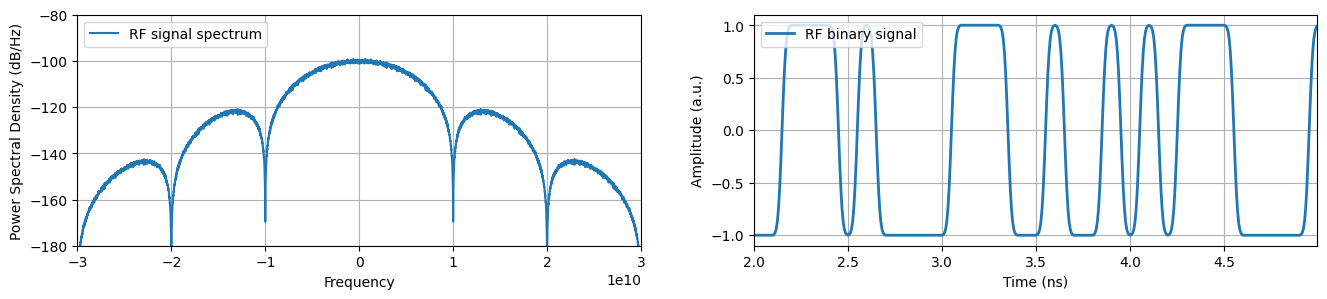

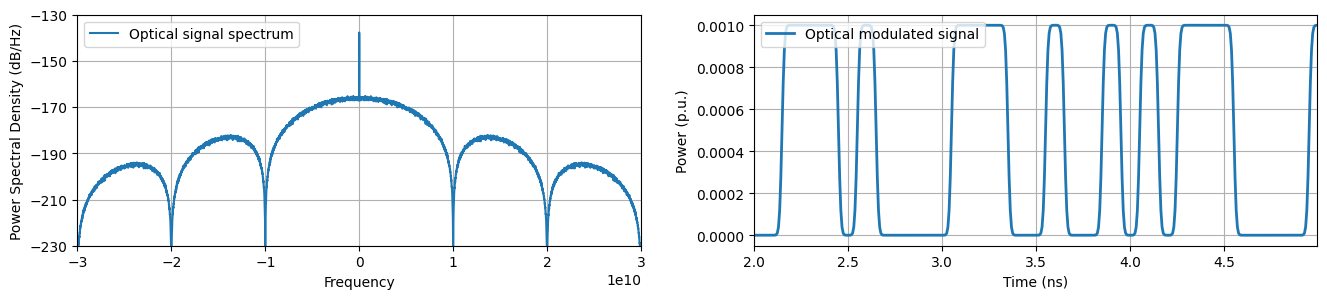

In [6]:
# simulation parameters
SpS = 16     # samples per symbol
M = 2        # order of the modulation format
Rs = 10e9    # Symbol rate (for OOK case Rs = Rb)
Fs = Rs*SpS  # Sampling frequency
Ts = 1/Fs    # Sampling period

# Laser power
Pi_dBm = 0         # laser optical power at the input of the MZM in dBm
Pi = dBm2W(Pi_dBm) # convert from dBm to W

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=100000)

# generate 2-PAM modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = mzm(Ai, sigTx, paramMZM)

print('Average power of the modulated optical signal [mW]: %.3f mW'%(signal_power(sigTxo)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

fig, axs = plt.subplots(1, 2, figsize=(16,3))
interval = np.arange(16*20,16*50)
t = interval*Ts/1e-9

# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'RF signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, sigTx[interval], label = 'RF binary signal', linewidth=2)
axs[1].set_ylabel('Amplitude (a.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

fig, axs = plt.subplots(1, 2, figsize=(16,3))
# plot psd
axs[0].set_xlim(-3*Rs,3*Rs);
axs[0].set_ylim(-230,-130);
axs[0].psd(np.abs(sigTxo)**2, Fs=Fs, NFFT = 16*1024, sides='twosided', label = 'Optical signal spectrum')
axs[0].legend(loc='upper left');

axs[1].plot(t, np.abs(sigTxo[interval])**2, label = 'Optical modulated signal', linewidth=2)
axs[1].set_ylabel('Power (p.u.)')
axs[1].set_xlabel('Time (ns)')
axs[1].set_xlim(min(t),max(t))
axs[1].legend(loc='upper left')
axs[1].grid()

### Linear fiber channel model (fiber + EDFA opt. amplifier)

In [7]:
# linear optical channel
paramCh = parameters()
paramCh.L = 100         # total link distance [km]
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

sigCh = linearFiberChannel(sigTxo, paramCh)

# receiver pre-amplifier
paramEDFA = parameters()
paramEDFA.G = paramCh.α*paramCh.L    # edfa gain
paramEDFA.NF = 4.5   # edfa noise figure
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

sigCh = edfa(sigCh, paramEDFA)

### Direct-detection (DD) pin receiver model

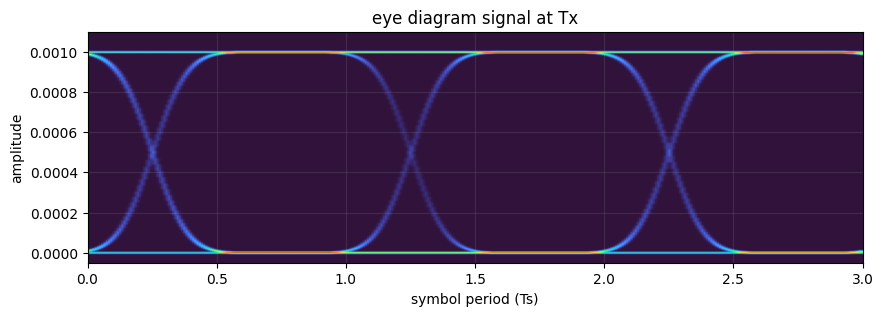

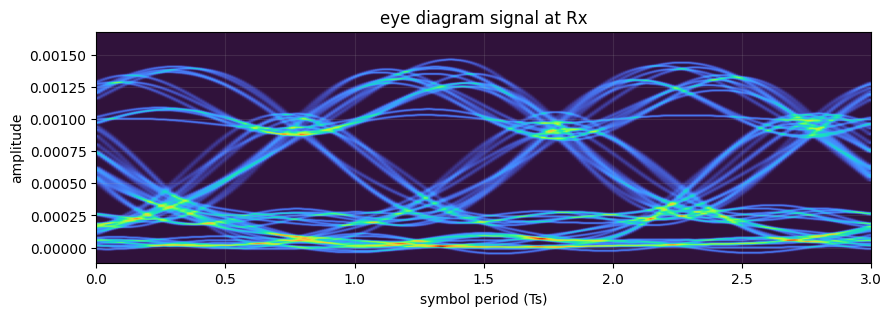

In [8]:
# ideal photodiode (noiseless, no bandwidth limitation)
paramPD = parameters()
paramPD.ideal = True
paramPD.Fs = Fs

I_Tx = photodiode(sigTxo.real, paramPD) # transmitted signal

# noisy photodiode (thermal noise + shot noise + bandwidth limitation)
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs
paramPD.ipd_sat = 5e-3

I_Rx = photodiode(sigCh, paramPD) # received signal after fiber channel and non-ideal PD

discard = 100
eyediagram(I_Tx[discard:-discard], I_Tx.size-2*discard, SpS, plotlabel='signal at Tx', ptype='fancy')
eyediagram(I_Rx[discard:-discard], I_Rx.size-2*discard, SpS, plotlabel='signal at Rx', ptype='fancy')

I0 = 0.23 
I1 = 2.13 
σ0 = 0.22 
σ1 = 0.15 
Optimal decision threshold Id = 1.37 
Q = 5.26 

Number of counted errors = 0 
BER = 0.00e+00 
Pb = 7.24e-08 


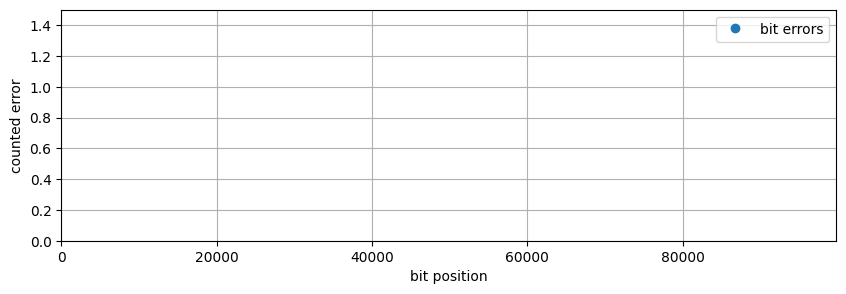

In [9]:
I_Rx = I_Rx/np.std(I_Rx)

# capture samples in the middle of signaling intervals
I_Rx = I_Rx[0::SpS]

# get received signal statistics
I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0

σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
Q = (I1-I0)/(σ1 + σ0) # factor Q

print('I0 = %.2f '%(I0))
print('I1 = %.2f '%(I1))
print('σ0 = %.2f '%(σ0))
print('σ1 = %.2f '%(σ1))
print('Optimal decision threshold Id = %.2f '%(Id))
print('Q = %.2f \n'%(Q))

# Apply the optimal decision rule
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx> Id] = 1
bitsRx[I_Rx<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
print('Number of counted errors = %d '%(err.sum()))
print('BER = %.2e '%(BER))
print('Pb = %.2e '%(Pb))

err = err*1.0
err[err==0] = np.nan

plt.plot(err,'o', label = 'bit errors')
plt.vlines(np.where(err>0), 0, 1)
plt.xlabel('bit position')
plt.ylabel('counted error')
plt.legend()
plt.grid()
plt.ylim(0, 1.5)
plt.xlim(0,err.size);

### Generate curve of BER vs receiver input power

In [10]:
# simulation parameters
SpS = 16        # Samples per symbol
M = 2           # order of the modulation format
Rs = 40e9       # Symbol rate (for the OOK case, Rs = Rb)
Fs = SpS*Rs     # Signal sampling frequency (samples/second)
Ts = 1/Fs       # Sampling period

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = 1.1*Rs
paramPD.Fs = Fs

powerValues = np.arange(-30,-14) # power values at the input of the pin receiver
BER = np.zeros(powerValues.shape)
Pb = np.zeros(powerValues.shape)

discard = 100
for indPi, Pi_dBm in enumerate(tqdm(powerValues)):

    Pi = dBm2W(Pi_dBm+3) # optical signal power in W at the MZM input

    # generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=10**6)
    n = np.arange(0, bitsTx.size)

    # generate ook modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx) # power normalization

    # upsampling
    symbolsUp = upsample(symbTx, SpS)

    # pulse formatting
    sigTx = firFilter(pulse, symbolsUp)

    # optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # pin receiver
    I_Rx = photodiode(sigTxo.real, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # capture samples in the middle of signaling intervals
    I_Rx = I_Rx[0::SpS]

    # get received signal statistics

    I1 = np.mean(I_Rx[bitsTx==1]) # average value of I1
    I0 = np.mean(I_Rx[bitsTx==0]) # average value of I0

    σ1 = np.std(I_Rx[bitsTx==1]) # standard deviation σ1 of I1
    σ0 = np.std(I_Rx[bitsTx==0]) # standard deviation σ0 of I0

    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # optimal decision threshold
    Q = (I1-I0)/(σ1 + σ0) # Q-factor

    # Aplica a regra de decisão ótima
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx>  Id] = 1
    bitsRx[I_Rx<= Id] = 0

    err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
    BER[indPi] = np.mean(err)
    Pb[indPi] = 0.5*erfc(Q/np.sqrt(2)) # probability of bit error (theory)

  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-11-929d5377b018>:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(powerValues, np.log10(BER),'o',label='BER')


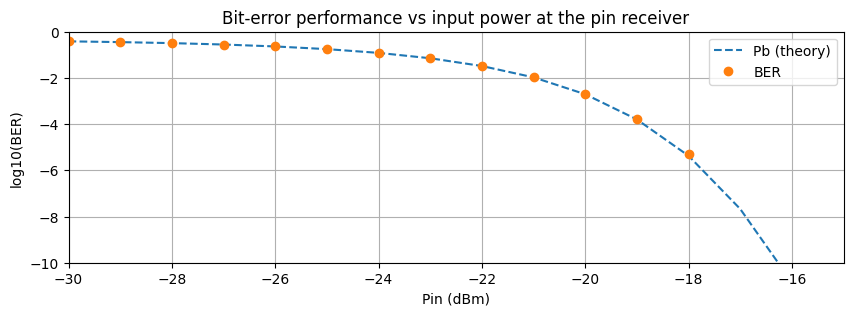

In [11]:
plt.figure()
plt.plot(powerValues, np.log10(Pb),'--',label='Pb (theory)')
plt.plot(powerValues, np.log10(BER),'o',label='BER')
plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('Pin (dBm)');
plt.title('Bit-error performance vs input power at the pin receiver')
plt.legend();
plt.ylim(-10,0);
plt.xlim(min(powerValues), max(powerValues));

LENGTH 10-100KM

Analyzing fiber lengths:   0%|          | 0/10 [00:00<?, ?it/s]

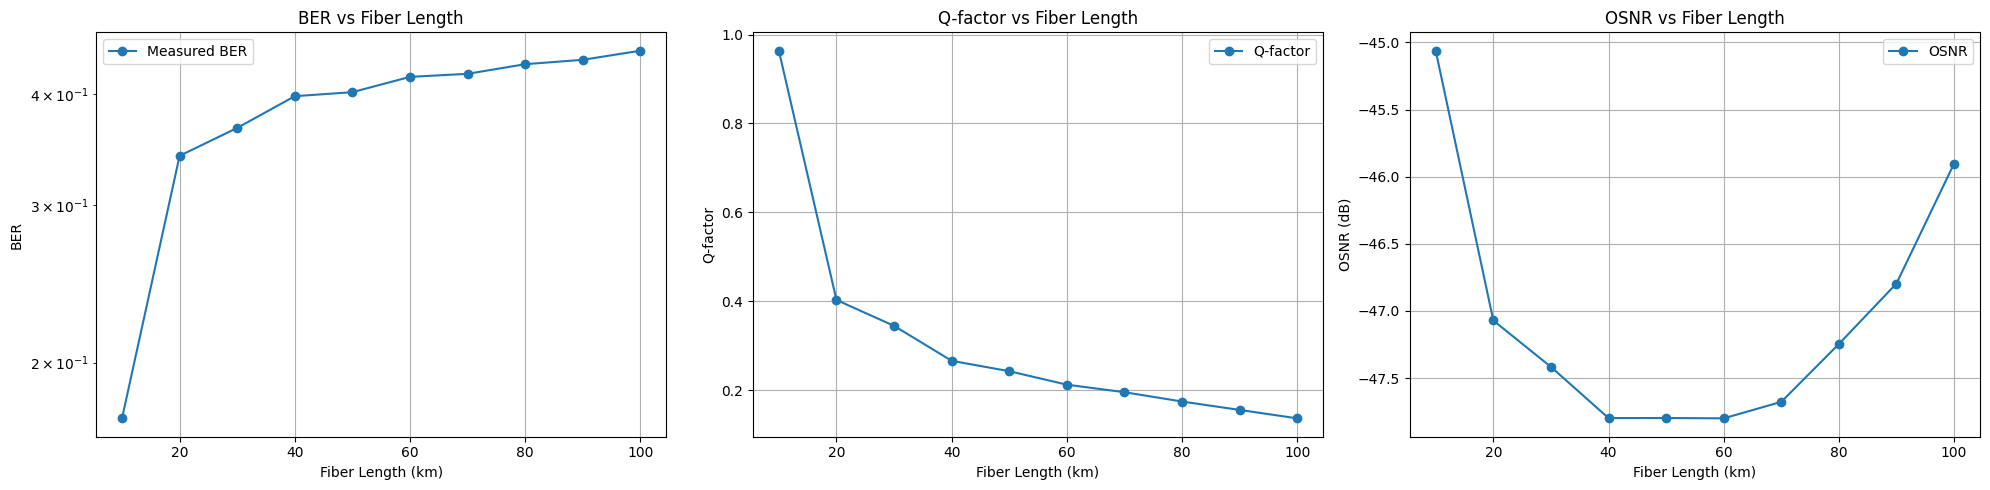

In [12]:
# Import required libraries
import numpy as np
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.dsp.core import upsample, pulseShape, lowPassFIR, pnorm, signal_power
try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter
from optic.utils import parameters, dBm2W
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm

# Simulation parameters for fiber length analysis
SpS = 16        # Samples per symbol
M = 2           # order of the modulation format
Rs = 40e9       # Symbol rate (for the OOK case, Rs = Rb)
Fs = SpS*Rs     # Signal sampling frequency (samples/second)
Ts = 1/Fs       # Sampling period

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# NRZ pulse shaping
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# Photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = 1.1*Rs
paramPD.Fs = Fs

# Fixed input power for fiber length analysis
Pi_dBm = -20  # Input power in dBm
Pi = dBm2W(Pi_dBm + 3)  # Convert to Watts

# Fiber lengths to analyze
fiber_lengths = np.arange(10, 110, 10)  # 10 to 100 km in steps of 10 km
BER_length = np.zeros(fiber_lengths.shape)
Q_factors = np.zeros(fiber_lengths.shape)
OSNR = np.zeros(fiber_lengths.shape)

# Initialize channel parameters
paramCh = parameters()
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

# EDFA parameters
paramEDFA = parameters()
paramEDFA.NF = 4.5   # noise figure
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

discard = 100
for ind, length in enumerate(tqdm(fiber_lengths, desc="Analyzing fiber lengths")):
    # Update fiber length
    paramCh.L = length
    paramEDFA.G = paramCh.α * length  # Compensate for fiber loss

    # Generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=10**6)

    # Generate OOK modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx)

    # Upsampling and pulse shaping
    symbolsUp = upsample(symbTx, SpS)
    sigTx = firFilter(pulse, symbolsUp)

    # Optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # Fiber propagation
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # EDFA amplification
    sigCh = edfa(sigCh, paramEDFA)

    # Photodetection
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # Sample at symbol centers
    I_Rx = I_Rx[0::SpS]

    # Calculate signal statistics
    I1 = np.mean(I_Rx[bitsTx==1])
    I0 = np.mean(I_Rx[bitsTx==0])
    σ1 = np.std(I_Rx[bitsTx==1])
    σ0 = np.std(I_Rx[bitsTx==0])

    # Calculate Q-factor and decision threshold
    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0)
    Q = (I1-I0)/(σ1 + σ0)
    Q_factors[ind] = Q

    # Calculate OSNR (simplified estimation)
    signal_power = np.mean(np.abs(sigCh)**2)
    noise_power = σ0**2
    OSNR[ind] = 10*np.log10(signal_power/noise_power)

    # Bit decision and error counting
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx > Id] = 1
    bitsRx[I_Rx <= Id] = 0

    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER_length[ind] = np.mean(err)

# Create subplots for visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot BER vs Length
ax1.semilogy(fiber_lengths, BER_length, 'o-', label='Measured BER')
ax1.grid(True)
ax1.set_xlabel('Fiber Length (km)')
ax1.set_ylabel('BER')
ax1.set_title('BER vs Fiber Length')
ax1.legend()

# Plot Q-factor vs Length
ax2.plot(fiber_lengths, Q_factors, 'o-', label='Q-factor')
ax2.grid(True)
ax2.set_xlabel('Fiber Length (km)')
ax2.set_ylabel('Q-factor')
ax2.set_title('Q-factor vs Fiber Length')
ax2.legend()

# Plot OSNR vs Length
ax3.plot(fiber_lengths, OSNR, 'o-', label='OSNR')
ax3.grid(True)
ax3.set_xlabel('Fiber Length (km)')
ax3.set_ylabel('OSNR (dB)')
ax3.set_title('OSNR vs Fiber Length')
ax3.legend()

plt.tight_layout()
plt.show()

FIBER DESPERSION 0-20ps

Analyzing dispersion:   0%|          | 0/11 [00:00<?, ?it/s]

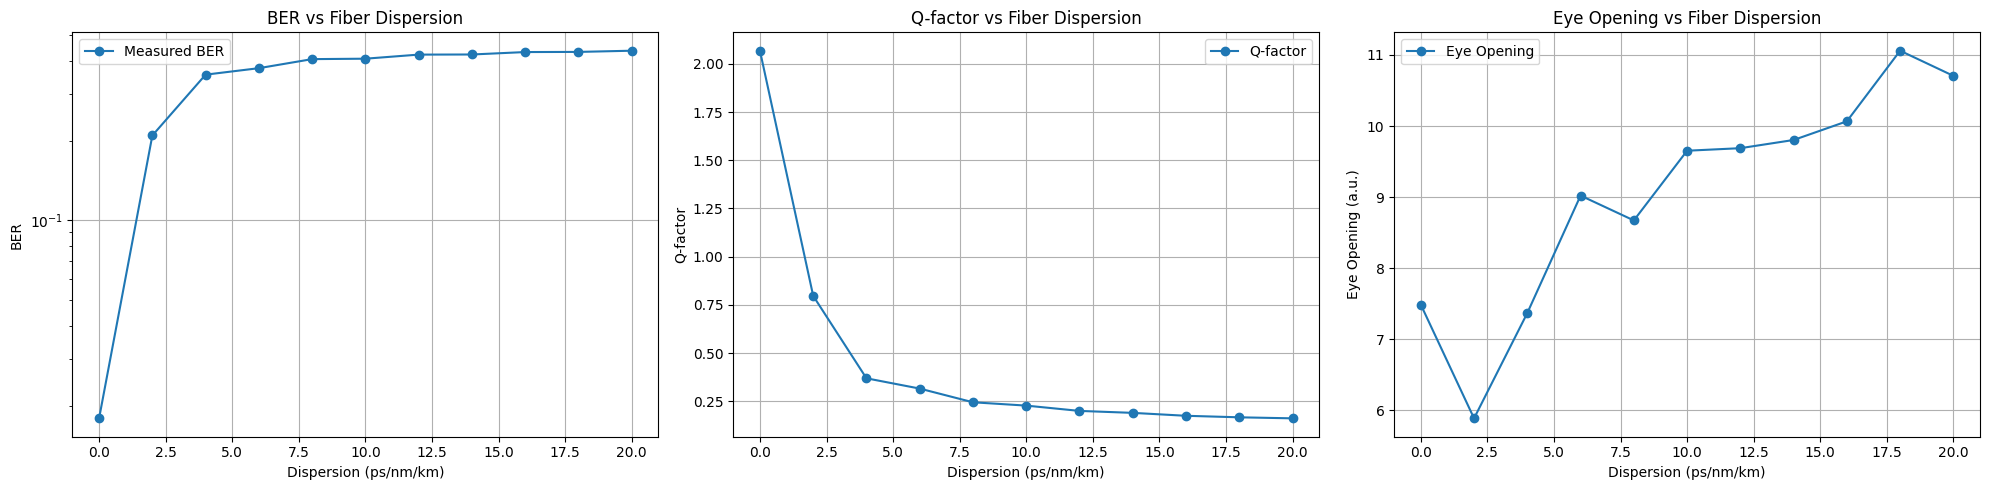


Key Findings:
Optimal dispersion value (lowest BER): 0.00 ps/nm/km
Maximum Q-factor: 2.07
Maximum eye opening: 11.06


In [13]:

# Simulation parameters for dispersion analysis
SpS = 16
M = 2
Rs = 40e9
Fs = SpS*Rs
Ts = 1/Fs

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# NRZ pulse shaping
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# Photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = 1.1*Rs
paramPD.Fs = Fs

# Fixed input power and length for dispersion analysis
Pi_dBm = -20
Pi = dBm2W(Pi_dBm + 3)
fixed_length = 80  # km

# Dispersion values to analyze
dispersion_values = np.linspace(0, 20, 11)  # From 0 to 20 ps/nm/km
BER_dispersion = np.zeros(dispersion_values.shape)
Q_factors_dispersion = np.zeros(dispersion_values.shape)
eye_openings = np.zeros(dispersion_values.shape)

# Initialize channel parameters
paramCh = parameters()
paramCh.L = fixed_length
paramCh.α = 0.2
paramCh.Fc = 193.1e12
paramCh.Fs = Fs

# EDFA parameters
paramEDFA = parameters()
paramEDFA.NF = 4.5
paramEDFA.G = paramCh.α * fixed_length
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

discard = 100
for ind, D in enumerate(tqdm(dispersion_values, desc="Analyzing dispersion")):
    # Update dispersion parameter
    paramCh.D = D

    # Generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=10**6)

    # Generate OOK modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx)

    # Upsampling and pulse shaping
    symbolsUp = upsample(symbTx, SpS)
    sigTx = firFilter(pulse, symbolsUp)

    # Optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # Fiber propagation
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # EDFA amplification
    sigCh = edfa(sigCh, paramEDFA)

    # Photodetection
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # Calculate eye opening (difference between min of ones and max of zeros)
    eye_matrix = I_Rx[:-SpS].reshape(-1, SpS)
    eye_openings[ind] = np.abs(np.min(eye_matrix[bitsTx[:-1]==1]) -
                              np.max(eye_matrix[bitsTx[:-1]==0]))

    # Sample at symbol centers
    I_Rx = I_Rx[0::SpS]

    # Calculate signal statistics
    I1 = np.mean(I_Rx[bitsTx==1])
    I0 = np.mean(I_Rx[bitsTx==0])
    σ1 = np.std(I_Rx[bitsTx==1])
    σ0 = np.std(I_Rx[bitsTx==0])

    # Calculate Q-factor and decision threshold
    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0)
    Q = (I1-I0)/(σ1 + σ0)
    Q_factors_dispersion[ind] = Q

    # Bit decision and error counting
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx > Id] = 1
    bitsRx[I_Rx <= Id] = 0

    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER_dispersion[ind] = np.mean(err)

# Create subplots for visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot BER vs Dispersion
ax1.semilogy(dispersion_values, BER_dispersion, 'o-', label='Measured BER')
ax1.grid(True)
ax1.set_xlabel('Dispersion (ps/nm/km)')
ax1.set_ylabel('BER')
ax1.set_title('BER vs Fiber Dispersion')
ax1.legend()

# Plot Q-factor vs Dispersion
ax2.plot(dispersion_values, Q_factors_dispersion, 'o-', label='Q-factor')
ax2.grid(True)
ax2.set_xlabel('Dispersion (ps/nm/km)')
ax2.set_ylabel('Q-factor')
ax2.set_title('Q-factor vs Fiber Dispersion')
ax2.legend()

# Plot Eye Opening vs Dispersion
ax3.plot(dispersion_values, eye_openings, 'o-', label='Eye Opening')
ax3.grid(True)
ax3.set_xlabel('Dispersion (ps/nm/km)')
ax3.set_ylabel('Eye Opening (a.u.)')
ax3.set_title('Eye Opening vs Fiber Dispersion')
ax3.legend()

plt.tight_layout()
plt.show()

# Print key findings
print("\nKey Findings:")
print(f"Optimal dispersion value (lowest BER): {dispersion_values[np.argmin(BER_dispersion)]:.2f} ps/nm/km")
print(f"Maximum Q-factor: {np.max(Q_factors_dispersion):.2f}")
print(f"Maximum eye opening: {np.max(eye_openings):.2f}")

EYE DIAGRAM FOR DISPERSION

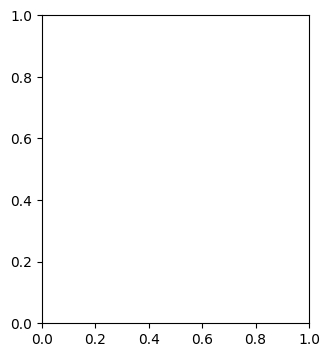

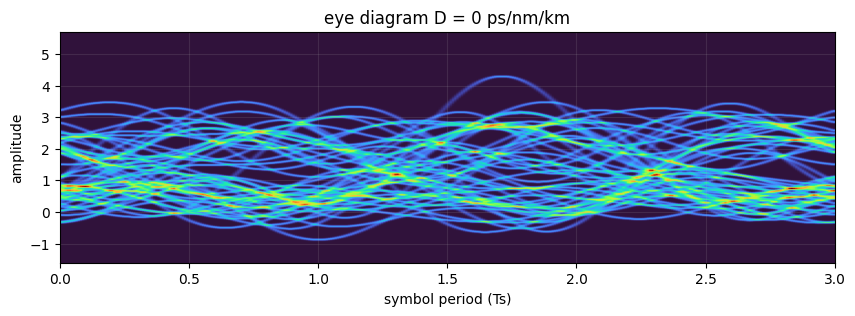

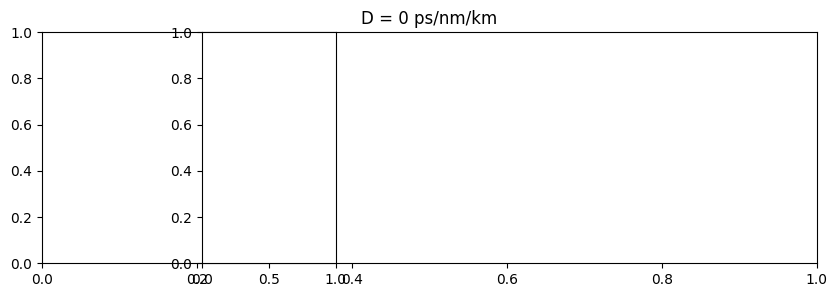

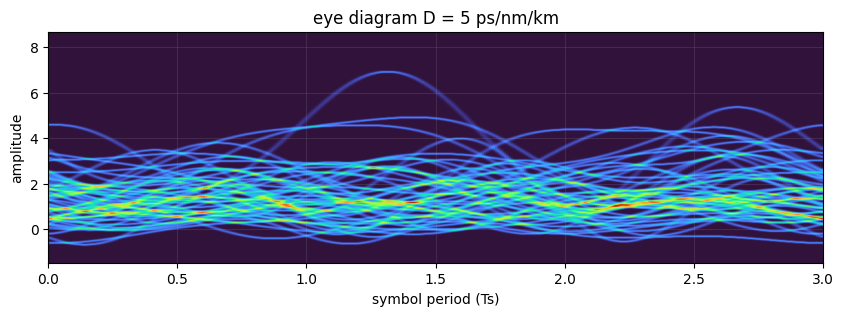

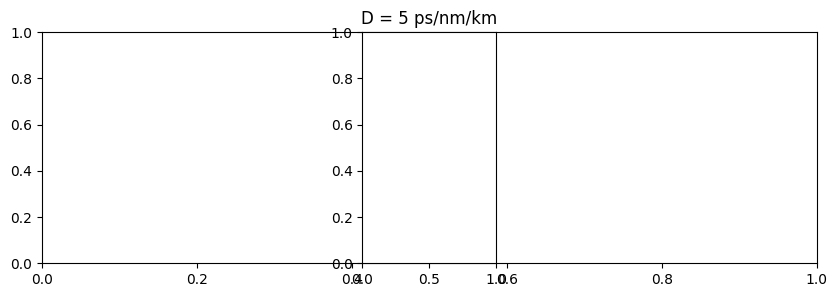

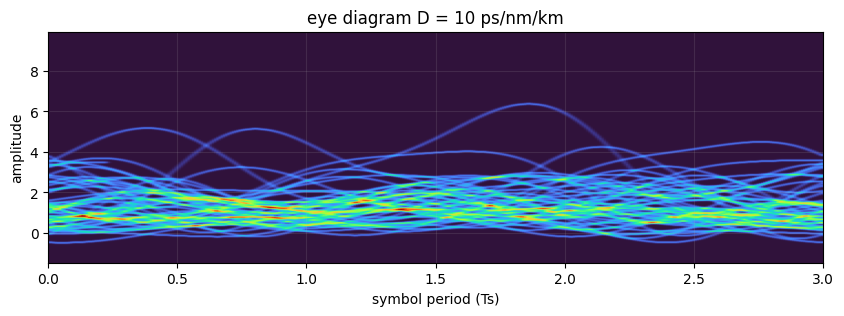

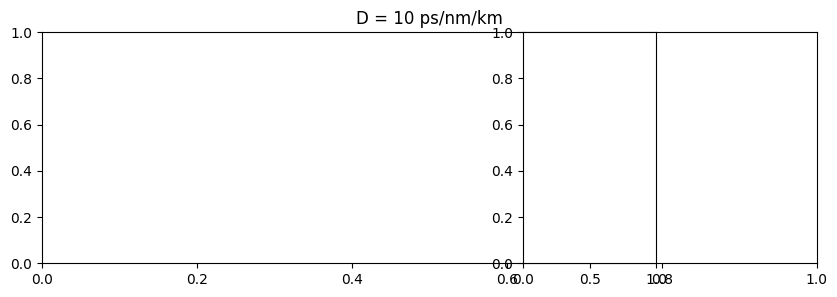

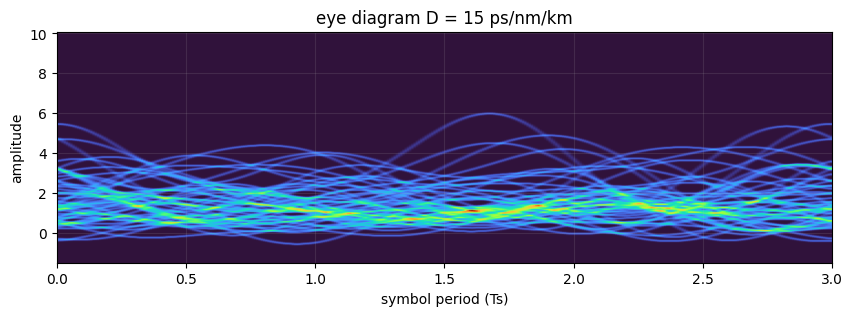

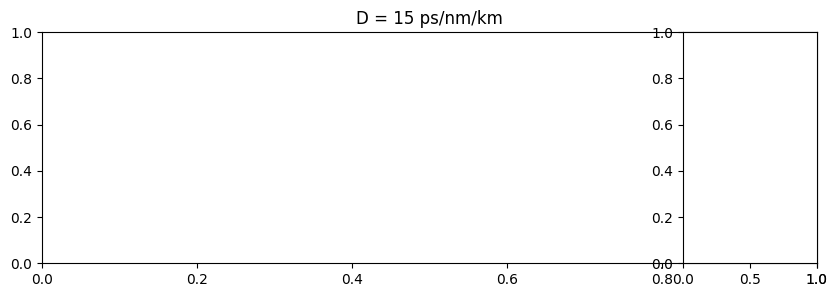

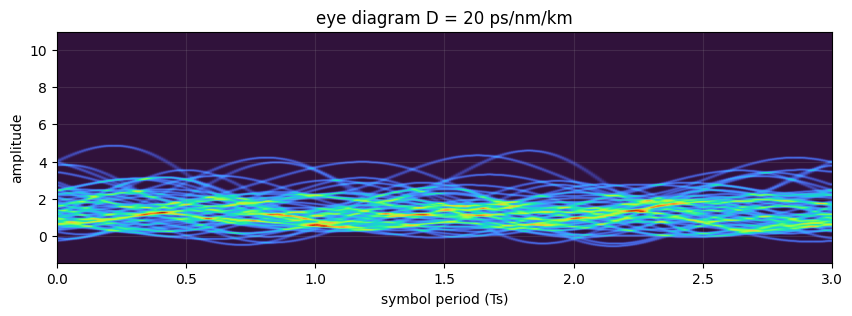

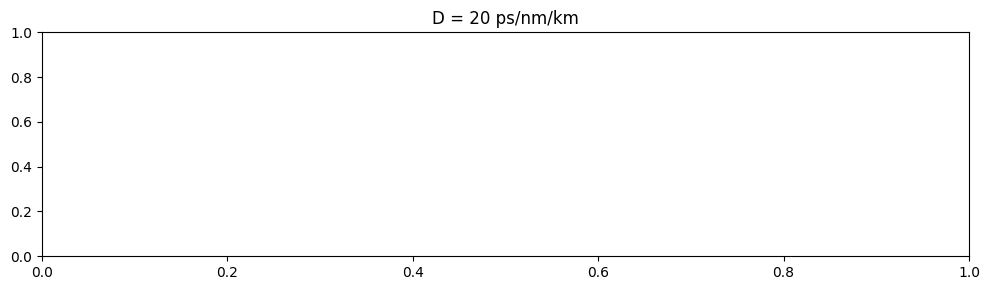

Analyzing dispersion:   0%|          | 0/11 [00:00<?, ?it/s]

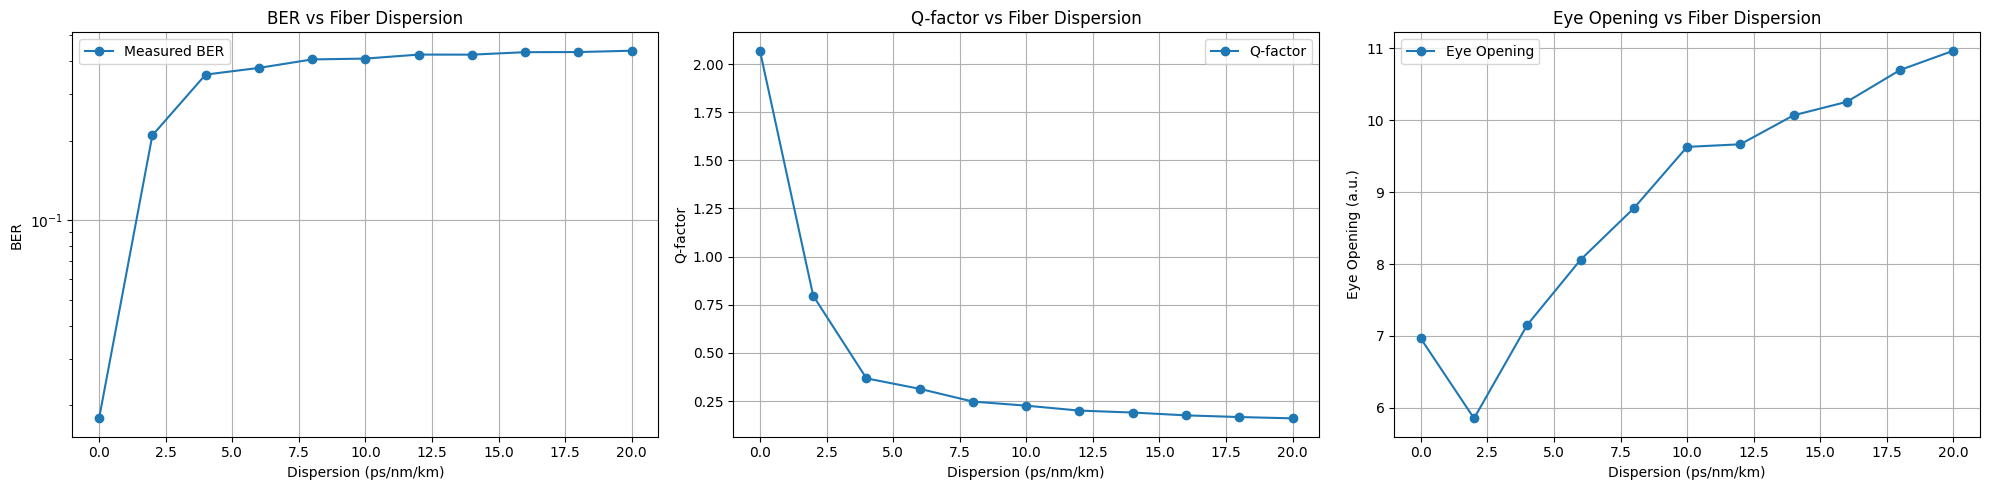


Key Findings:
Optimal dispersion value (lowest BER): 0.00 ps/nm/km
Maximum Q-factor: 2.07
Maximum eye opening: 10.96


In [14]:

from optic.plot import eyediagram

# Simulation parameters for dispersion analysis
SpS = 16
M = 2
Rs = 40e9
Fs = SpS*Rs
Ts = 1/Fs

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# NRZ pulse shaping
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# Photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = 1.1*Rs
paramPD.Fs = Fs

# Fixed input power and length for dispersion analysis
Pi_dBm = -20
Pi = dBm2W(Pi_dBm + 3)
fixed_length = 80  # km

# Select specific dispersion values for eye diagram comparison
dispersion_values_eye = [0, 5, 10, 15, 20]  # ps/nm/km
eye_signals = []  # Store signals for eye diagram

# Initialize channel parameters
paramCh = parameters()
paramCh.L = fixed_length
paramCh.α = 0.2
paramCh.Fc = 193.1e12
paramCh.Fs = Fs

# EDFA parameters
paramEDFA = parameters()
paramEDFA.NF = 4.5
paramEDFA.G = paramCh.α * fixed_length
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

# Generate signals and store eye diagrams for selected dispersion values
for D in dispersion_values_eye:
    # Update dispersion parameter
    paramCh.D = D

    # Generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=10**5)  # Reduced size for eye diagram

    # Generate OOK modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx)

    # Upsampling and pulse shaping
    symbolsUp = upsample(symbTx, SpS)
    sigTx = firFilter(pulse, symbolsUp)

    # Optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # Fiber propagation
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # EDFA amplification
    sigCh = edfa(sigCh, paramEDFA)

    # Photodetection
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # Store received signal for eye diagram
    eye_signals.append(I_Rx)

# Plot eye diagrams
plt.figure(figsize=(20, 4))
for idx, (D, sig) in enumerate(zip(dispersion_values_eye, eye_signals)):
    plt.subplot(1, len(dispersion_values_eye), idx+1)
    eyediagram(sig[100:-100], sig.size-200, SpS, plotlabel=f'D = {D} ps/nm/km', ptype='fancy')
    plt.title(f'D = {D} ps/nm/km')
plt.tight_layout()
plt.show()

# Now run the full dispersion analysis with more points for the metrics
dispersion_values = np.linspace(0, 20, 11)  # From 0 to 20 ps/nm/km
BER_dispersion = np.zeros(dispersion_values.shape)
Q_factors_dispersion = np.zeros(dispersion_values.shape)
eye_openings = np.zeros(dispersion_values.shape)

discard = 100
for ind, D in enumerate(tqdm(dispersion_values, desc="Analyzing dispersion")):
    # Update dispersion parameter
    paramCh.D = D

    # Generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=10**6)

    # Generate OOK modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx)

    # Upsampling and pulse shaping
    symbolsUp = upsample(symbTx, SpS)
    sigTx = firFilter(pulse, symbolsUp)

    # Optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # Fiber propagation
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # EDFA amplification
    sigCh = edfa(sigCh, paramEDFA)

    # Photodetection
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # Calculate eye opening
    eye_matrix = I_Rx[:-SpS].reshape(-1, SpS)
    eye_openings[ind] = np.abs(np.min(eye_matrix[bitsTx[:-1]==1]) -
                              np.max(eye_matrix[bitsTx[:-1]==0]))

    # Sample at symbol centers
    I_Rx = I_Rx[0::SpS]

    # Calculate signal statistics
    I1 = np.mean(I_Rx[bitsTx==1])
    I0 = np.mean(I_Rx[bitsTx==0])
    σ1 = np.std(I_Rx[bitsTx==1])
    σ0 = np.std(I_Rx[bitsTx==0])

    # Calculate Q-factor and decision threshold
    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0)
    Q = (I1-I0)/(σ1 + σ0)
    Q_factors_dispersion[ind] = Q

    # Bit decision and error counting
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx > Id] = 1
    bitsRx[I_Rx <= Id] = 0

    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER_dispersion[ind] = np.mean(err)

# Create subplots for visualization of metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot BER vs Dispersion
ax1.semilogy(dispersion_values, BER_dispersion, 'o-', label='Measured BER')
ax1.grid(True)
ax1.set_xlabel('Dispersion (ps/nm/km)')
ax1.set_ylabel('BER')
ax1.set_title('BER vs Fiber Dispersion')
ax1.legend()

# Plot Q-factor vs Dispersion
ax2.plot(dispersion_values, Q_factors_dispersion, 'o-', label='Q-factor')
ax2.grid(True)
ax2.set_xlabel('Dispersion (ps/nm/km)')
ax2.set_ylabel('Q-factor')
ax2.set_title('Q-factor vs Fiber Dispersion')
ax2.legend()

# Plot Eye Opening vs Dispersion
ax3.plot(dispersion_values, eye_openings, 'o-', label='Eye Opening')
ax3.grid(True)
ax3.set_xlabel('Dispersion (ps/nm/km)')
ax3.set_ylabel('Eye Opening (a.u.)')
ax3.set_title('Eye Opening vs Fiber Dispersion')
ax3.legend()

plt.tight_layout()
plt.show()

# Print key findings
print("\nKey Findings:")
print(f"Optimal dispersion value (lowest BER): {dispersion_values[np.argmin(BER_dispersion)]:.2f} ps/nm/km")
print(f"Maximum Q-factor: {np.max(Q_factors_dispersion):.2f}")
print(f"Maximum eye opening: {np.max(eye_openings):.2f}")

EFFECT OF RECIEVER BANDWIDTH 1GHz to 10Ghz

Analyzing receiver bandwidth:   0%|          | 0/10 [00:00<?, ?it/s]

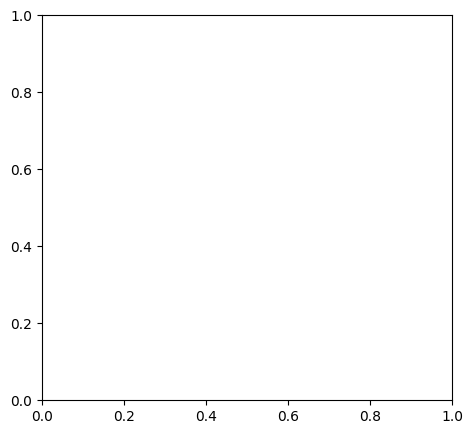

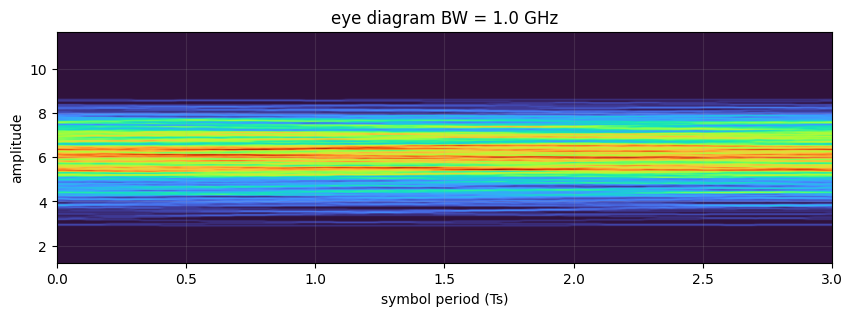

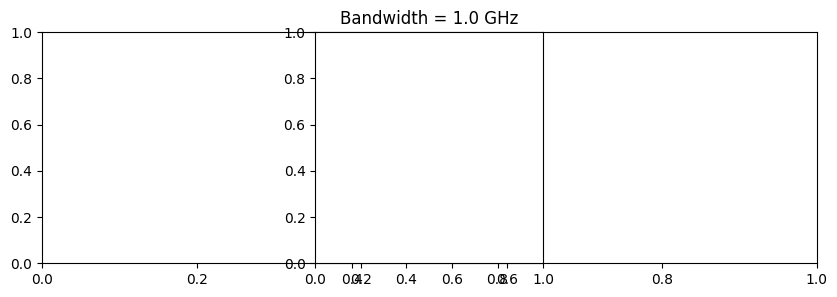

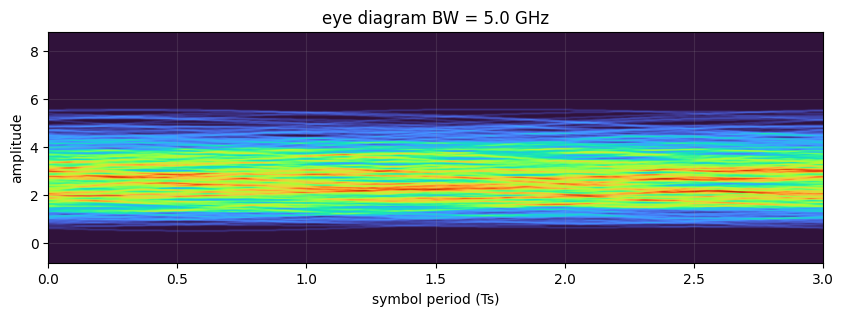

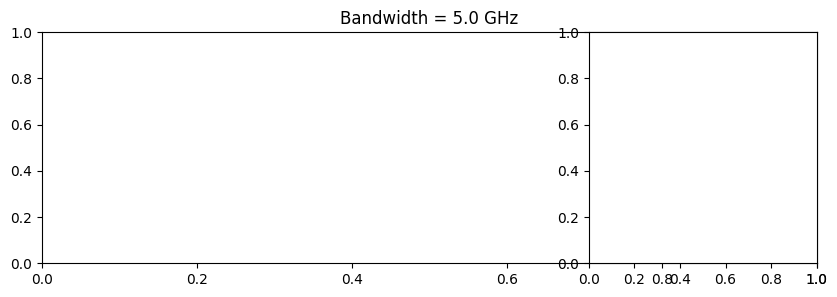

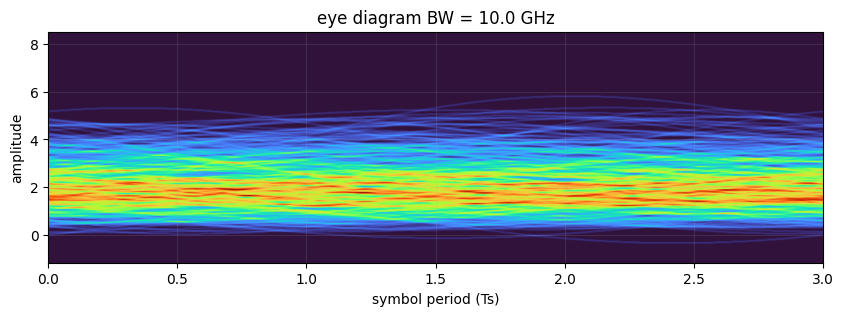

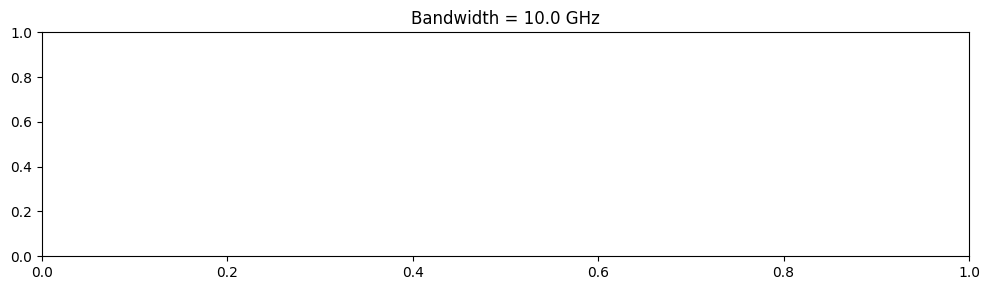

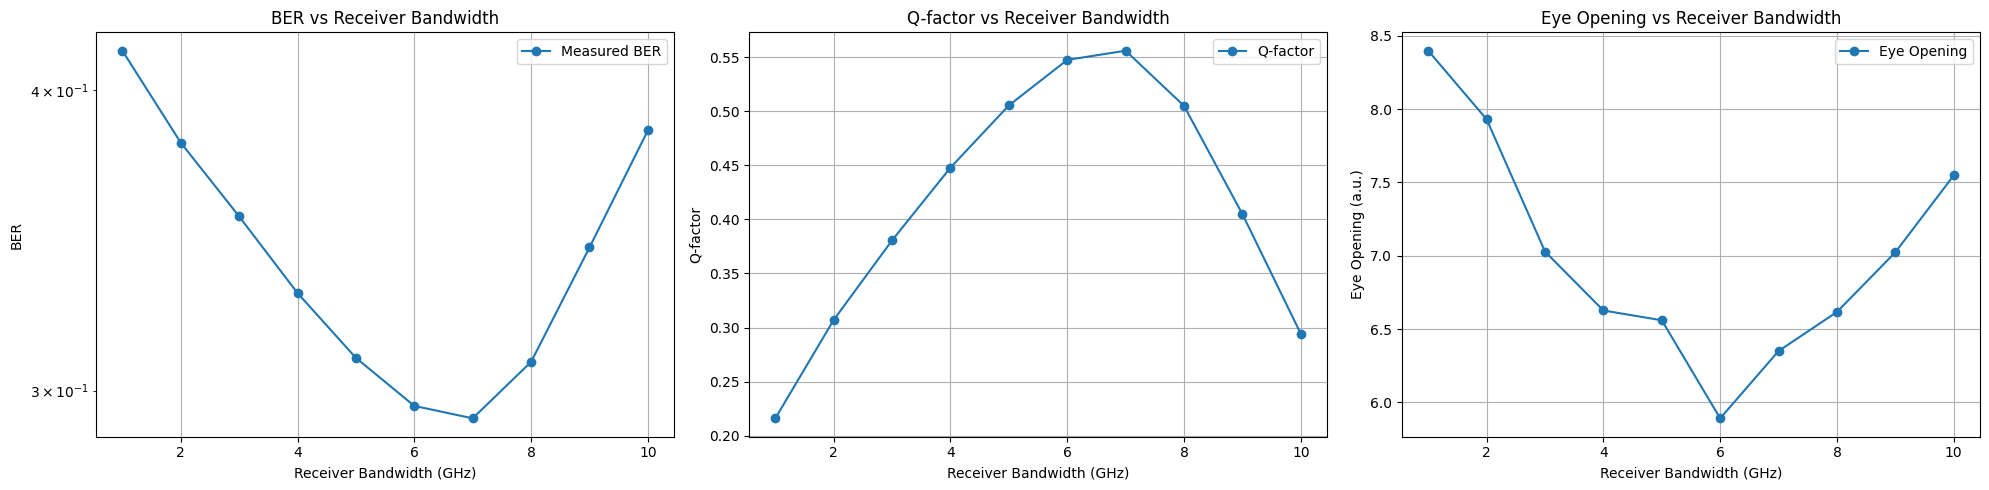


Key Findings:
Optimal receiver bandwidth (lowest BER): 7.00 GHz
Maximum Q-factor: 0.56 at 7.00 GHz
Maximum eye opening: 8.40 at 1.00 GHz

Symbol rate: 40.0 GHz
Nyquist rate: 20.0 GHz


In [15]:
# Import required libraries
import numpy as np
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.dsp.core import upsample, pulseShape, lowPassFIR, pnorm, signal_power
try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm

# Simulation parameters
SpS = 16        # Samples per symbol
M = 2           # order of the modulation format
Rs = 40e9       # Symbol rate (for the OOK case, Rs = Rb)
Fs = SpS*Rs     # Signal sampling frequency (samples/second)
Ts = 1/Fs       # Sampling period

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# NRZ pulse shaping
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# Fixed input power
Pi_dBm = -20
Pi = dBm2W(Pi_dBm + 3)

# Fiber parameters (fixed for this analysis)
paramCh = parameters()
paramCh.L = 80         # total link distance [km]
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

# EDFA parameters
paramEDFA = parameters()
paramEDFA.G = paramCh.α * paramCh.L    # edfa gain
paramEDFA.NF = 4.5   # edfa noise figure
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

# Bandwidth values to analyze (from 1 GHz to 10 GHz)
bandwidth_values = np.linspace(1e9, 10e9, 10)  # 10 points between 1 GHz and 10 GHz
BER_vs_bandwidth = np.zeros(bandwidth_values.shape)
Q_factors = np.zeros(bandwidth_values.shape)
eye_openings = np.zeros(bandwidth_values.shape)

# Store signals for eye diagram comparison at select bandwidths
selected_bw_indices = [0, 4, 9]  # 1 GHz, ~5 GHz, 10 GHz
eye_signals = []

discard = 100
for ind, bw in enumerate(tqdm(bandwidth_values, desc="Analyzing receiver bandwidth")):
    # Generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=10**6)

    # Generate OOK modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')
    symbTx = pnorm(symbTx)

    # Upsampling and pulse shaping
    symbolsUp = upsample(symbTx, SpS)
    sigTx = firFilter(pulse, symbolsUp)

    # Optical modulation
    Ai = np.sqrt(Pi)
    sigTxo = mzm(Ai, sigTx, paramMZM)

    # Fiber propagation
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # EDFA amplification
    sigCh = edfa(sigCh, paramEDFA)

    # Photodiode with varying bandwidth
    paramPD = parameters()
    paramPD.ideal = False
    paramPD.B = bw
    paramPD.Fs = Fs
    paramPD.ipd_sat = 5e-3  # Use default saturation current

    # Photodetection
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # Store signal for eye diagram if it's one of the selected bandwidths
    if ind in selected_bw_indices:
        eye_signals.append((bw/1e9, I_Rx.copy()))

    # Calculate eye opening
    eye_matrix = I_Rx[:-SpS].reshape(-1, SpS)
    eye_openings[ind] = np.abs(np.min(eye_matrix[bitsTx[:-1]==1]) -
                              np.max(eye_matrix[bitsTx[:-1]==0]))

    # Sample at symbol centers
    I_Rx = I_Rx[0::SpS]

    # Calculate signal statistics
    I1 = np.mean(I_Rx[bitsTx==1])
    I0 = np.mean(I_Rx[bitsTx==0])
    σ1 = np.std(I_Rx[bitsTx==1])
    σ0 = np.std(I_Rx[bitsTx==0])

    # Calculate Q-factor and decision threshold
    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0)
    Q = (I1-I0)/(σ1 + σ0)
    Q_factors[ind] = Q

    # Bit decision and error counting
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx > Id] = 1
    bitsRx[I_Rx <= Id] = 0

    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER_vs_bandwidth[ind] = np.mean(err)

# Plot eye diagrams for selected bandwidths
plt.figure(figsize=(18, 5))
for idx, (bw, sig) in enumerate(eye_signals):
    plt.subplot(1, len(selected_bw_indices), idx+1)
    eyediagram(sig[100:-100], sig.size-200, SpS, plotlabel=f'BW = {bw:.1f} GHz', ptype='fancy')
    plt.title(f'Bandwidth = {bw:.1f} GHz')
plt.tight_layout()
plt.show()

# Create subplots for performance metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot BER vs Bandwidth
ax1.semilogy(bandwidth_values/1e9, BER_vs_bandwidth, 'o-', label='Measured BER')
ax1.grid(True)
ax1.set_xlabel('Receiver Bandwidth (GHz)')
ax1.set_ylabel('BER')
ax1.set_title('BER vs Receiver Bandwidth')
ax1.legend()

# Plot Q-factor vs Bandwidth
ax2.plot(bandwidth_values/1e9, Q_factors, 'o-', label='Q-factor')
ax2.grid(True)
ax2.set_xlabel('Receiver Bandwidth (GHz)')
ax2.set_ylabel('Q-factor')
ax2.set_title('Q-factor vs Receiver Bandwidth')
ax2.legend()

# Plot Eye Opening vs Bandwidth
ax3.plot(bandwidth_values/1e9, eye_openings, 'o-', label='Eye Opening')
ax3.grid(True)
ax3.set_xlabel('Receiver Bandwidth (GHz)')
ax3.set_ylabel('Eye Opening (a.u.)')
ax3.set_title('Eye Opening vs Receiver Bandwidth')
ax3.legend()

plt.tight_layout()
plt.show()

# Print key findings
print("\nKey Findings:")
optimal_bw = bandwidth_values[np.argmin(BER_vs_bandwidth)]
print(f"Optimal receiver bandwidth (lowest BER): {optimal_bw/1e9:.2f} GHz")
print(f"Maximum Q-factor: {np.max(Q_factors):.2f} at {bandwidth_values[np.argmax(Q_factors)]/1e9:.2f} GHz")
print(f"Maximum eye opening: {np.max(eye_openings):.2f} at {bandwidth_values[np.argmax(eye_openings)]/1e9:.2f} GHz")

# Check if the bandwidth is sufficient for the symbol rate
nyquist_rate = Rs / 2
print(f"\nSymbol rate: {Rs/1e9:.1f} GHz")
print(f"Nyquist rate: {nyquist_rate/1e9:.1f} GHz")
if optimal_bw < nyquist_rate:
    print("Warning: Optimal bandwidth is below the Nyquist rate, which may cause intersymbol interference.")

Noise Impact 3dB to 8 dB

Analyzing receiver bandwidth:   0%|          | 0/10 [00:00<?, ?it/s]

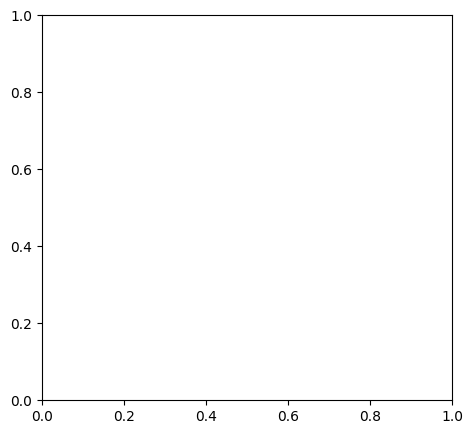

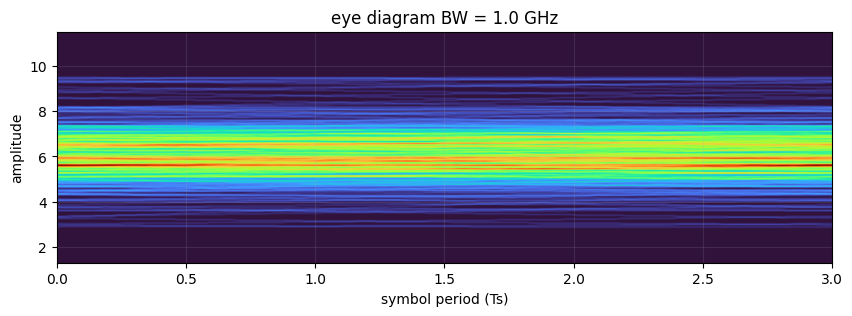

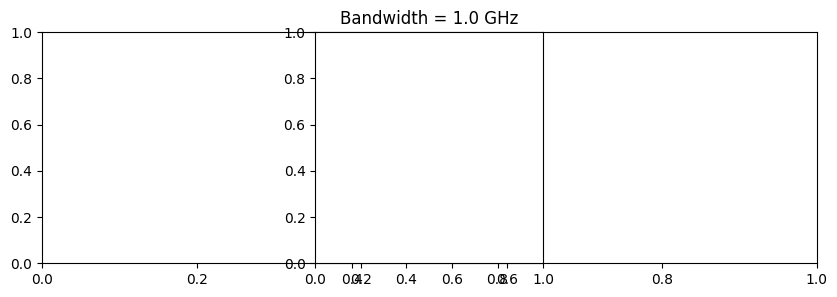

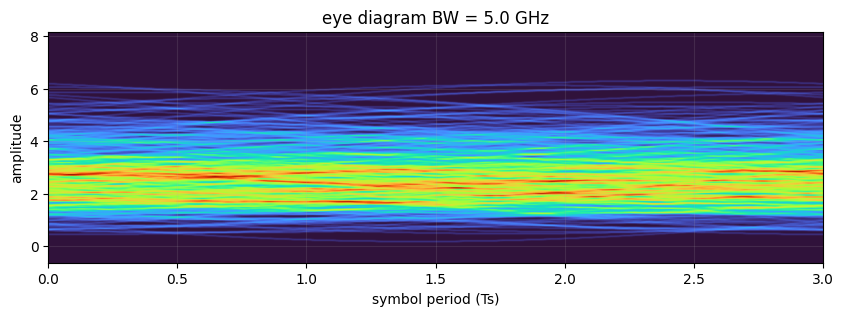

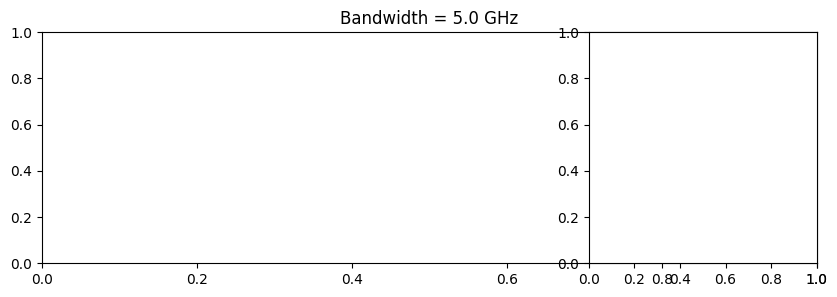

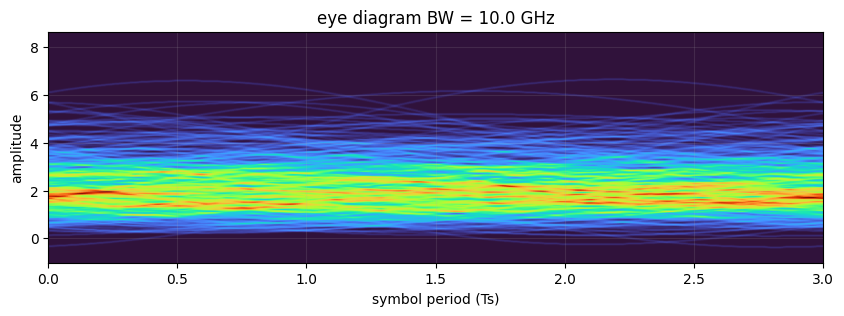

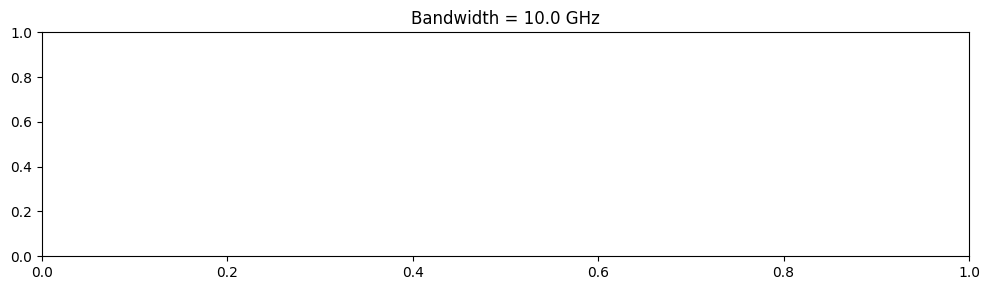

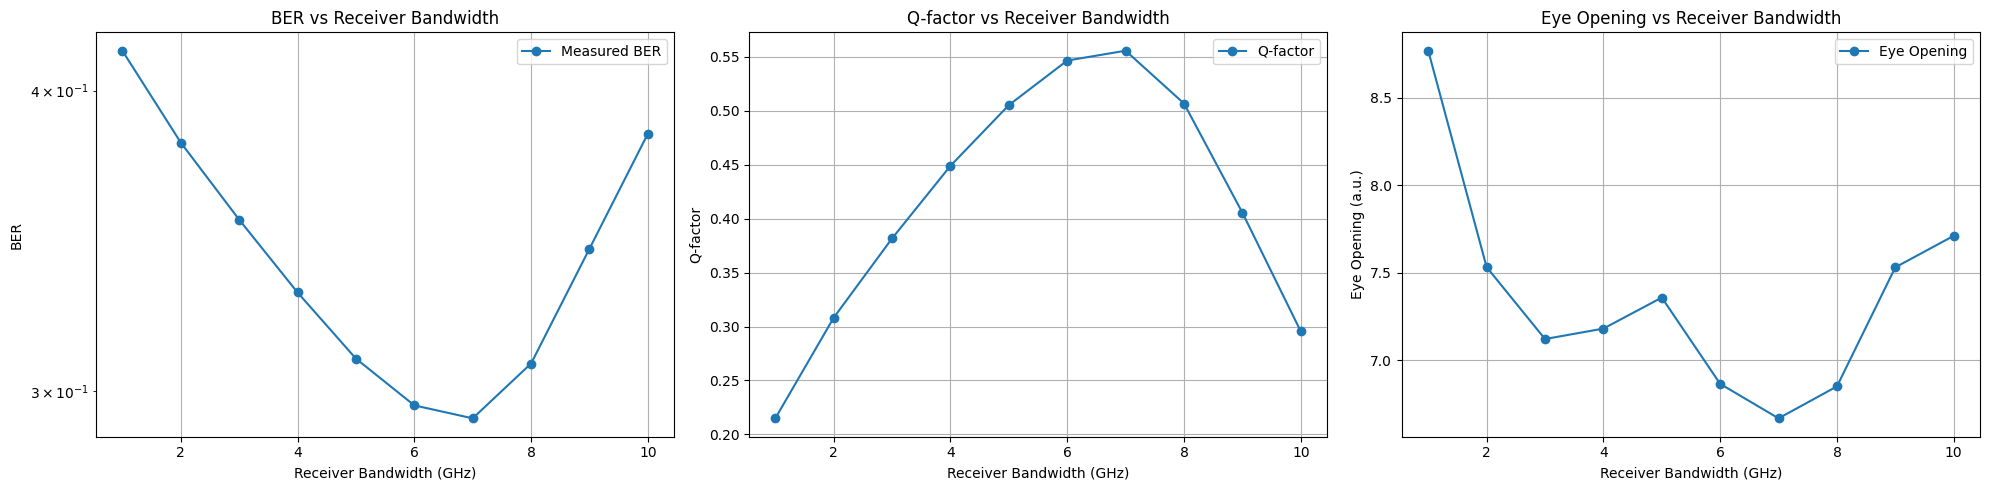


Key Findings:
Optimal receiver bandwidth (lowest BER): 7.00 GHz
Maximum Q-factor: 0.56 at 7.00 GHz
Maximum eye opening: 8.77 at 1.00 GHz

Symbol rate: 40.0 GHz
Nyquist rate: 20.0 GHz


In [16]:
import numpy as np
from optic.models.devices import mzm, photodiode, edfa
from optic.models.channels import linearFiberChannel
from optic.comm.modulation import modulateGray
from optic.dsp.core import upsample, pulseShape, pnorm
try:
    from optic.dsp.coreGPU import firFilter
except ImportError:
    from optic.dsp.core import firFilter
from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm

# Simulation parameters
SpS = 16        # Samples per symbol
M = 2           # Order of the modulation format (OOK)
Rs = 40e9       # Symbol rate (baud)
Fs = SpS*Rs     # Sampling frequency
Ts = 1/Fs       # Sampling period

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# Pulse shaping
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# Fixed input power
Pi_dBm = -20
Pi = dBm2W(Pi_dBm + 3)

# Fiber channel parameters
paramCh = parameters()
paramCh.L = 80         # Link distance [km]
paramCh.α = 0.2        # Fiber loss [dB/km]
paramCh.D = 16         # Dispersion [ps/nm/km]
paramCh.Fc = 193.1e12  # Central frequency [Hz]
paramCh.Fs = Fs        # Sampling frequency [Hz]

# EDFA parameters
paramEDFA = parameters()
paramEDFA.G = paramCh.α * paramCh.L    # EDFA gain to compensate for loss
paramEDFA.NF = 4.5                     # Noise figure [dB]
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs

# Receiver bandwidth values to analyze
bandwidth_values = np.linspace(1e9, 10e9, 10)  # 1 GHz to 10 GHz
BER_vs_bandwidth = np.zeros(bandwidth_values.shape)
Q_factors = np.zeros(bandwidth_values.shape)
eye_openings = np.zeros(bandwidth_values.shape)

# Select specific bandwidths for eye diagram visualization
selected_bw_indices = [0, 4, 9]  # 1 GHz, ~5.5 GHz, 10 GHz
eye_signals = []

# Generate a fixed bit sequence for consistent comparison
np.random.seed(42)
bitsTx = np.random.randint(2, size=10**6)

# Generate OOK modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')
symbTx = pnorm(symbTx)

# Upsampling and pulse shaping
symbolsUp = upsample(symbTx, SpS)
sigTx = firFilter(pulse, symbolsUp)

# Optical modulation
Ai = np.sqrt(Pi)
sigTxo = mzm(Ai, sigTx, paramMZM)

# Fiber propagation
sigCh = linearFiberChannel(sigTxo, paramCh)

# EDFA amplification
sigCh = edfa(sigCh, paramEDFA)

discard = 100
for ind, bw in enumerate(tqdm(bandwidth_values, desc="Analyzing receiver bandwidth")):
    # Configure photodiode with current bandwidth
    paramPD = parameters()
    paramPD.ideal = False
    paramPD.B = bw                # Variable bandwidth
    paramPD.Fs = Fs
    paramPD.ipd_sat = 5e-3        # Saturation current

    # Photodetection
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # Store signal for eye diagram if it's one of the selected bandwidths
    if ind in selected_bw_indices:
        eye_signals.append((bw/1e9, I_Rx.copy()))

    # Calculate eye opening
    eye_matrix = I_Rx[:-SpS].reshape(-1, SpS)
    eye_openings[ind] = np.abs(np.min(eye_matrix[bitsTx[:-1]==1]) -
                               np.max(eye_matrix[bitsTx[:-1]==0]))

    # Sample at symbol centers
    I_Rx_sampled = I_Rx[0::SpS]

    # Calculate signal statistics
    I1 = np.mean(I_Rx_sampled[bitsTx==1])
    I0 = np.mean(I_Rx_sampled[bitsTx==0])
    σ1 = np.std(I_Rx_sampled[bitsTx==1])
    σ0 = np.std(I_Rx_sampled[bitsTx==0])

    # Calculate Q-factor and decision threshold
    Id = (σ1*I0 + σ0*I1)/(σ1 + σ0)
    Q = (I1-I0)/(σ1 + σ0)
    Q_factors[ind] = Q

    # Bit decision and error counting
    bitsRx = np.empty(bitsTx.size)
    bitsRx[I_Rx_sampled > Id] = 1
    bitsRx[I_Rx_sampled <= Id] = 0

    err = np.logical_xor(bitsRx[discard:-discard], bitsTx[discard:-discard])
    BER_vs_bandwidth[ind] = np.mean(err)

# Plot eye diagrams for selected bandwidths
plt.figure(figsize=(18, 5))
for idx, (bw, sig) in enumerate(eye_signals):
    plt.subplot(1, len(selected_bw_indices), idx+1)
    eyediagram(sig[100:-100], sig.size-200, SpS, plotlabel=f'BW = {bw:.1f} GHz', ptype='fancy')
    plt.title(f'Bandwidth = {bw:.1f} GHz')
plt.tight_layout()
plt.show()

# Create subplots for performance metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot BER vs Bandwidth
ax1.semilogy(bandwidth_values/1e9, BER_vs_bandwidth, 'o-', label='Measured BER')
ax1.grid(True)
ax1.set_xlabel('Receiver Bandwidth (GHz)')
ax1.set_ylabel('BER')
ax1.set_title('BER vs Receiver Bandwidth')
ax1.legend()

# Plot Q-factor vs Bandwidth
ax2.plot(bandwidth_values/1e9, Q_factors, 'o-', label='Q-factor')
ax2.grid(True)
ax2.set_xlabel('Receiver Bandwidth (GHz)')
ax2.set_ylabel('Q-factor')
ax2.set_title('Q-factor vs Receiver Bandwidth')
ax2.legend()

# Plot Eye Opening vs Bandwidth
ax3.plot(bandwidth_values/1e9, eye_openings, 'o-', label='Eye Opening')
ax3.grid(True)
ax3.set_xlabel('Receiver Bandwidth (GHz)')
ax3.set_ylabel('Eye Opening (a.u.)')
ax3.set_title('Eye Opening vs Receiver Bandwidth')
ax3.legend()

plt.tight_layout()
plt.show()

# Print key findings
print("\nKey Findings:")
optimal_bw = bandwidth_values[np.argmin(BER_vs_bandwidth)]
max_Q_bw = bandwidth_values[np.argmax(Q_factors)]
max_eye_bw = bandwidth_values[np.argmax(eye_openings)]

print(f"Optimal receiver bandwidth (lowest BER): {optimal_bw/1e9:.2f} GHz")
print(f"Maximum Q-factor: {np.max(Q_factors):.2f} at {max_Q_bw/1e9:.2f} GHz")
print(f"Maximum eye opening: {np.max(eye_openings):.2f} at {max_eye_bw/1e9:.2f} GHz")

# Check if the bandwidth is sufficient for the symbol rate
nyquist_rate = Rs / 2
print(f"\nSymbol rate: {Rs/1e9:.1f} GHz")
print(f"Nyquist rate: {nyquist_rate/1e9:.1f} GHz")
if optimal_bw < nyquist_rate:
    print("Warning: Optimal bandwidth is below the Nyquist rate, which may cause intersymbol interference.")
else:
    print(f"The optimal bandwidth ({optimal_bw/1e9:.2f} GHz) is above the Nyquist rate, which is good for signal integrity.")

DIFFERENT MODULATIONS IN OOK

Testing QPSK:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-19-1cb8f78c3967>:68: ComplexWarning: Casting complex values to real discards the imaginary part
  bitsRx = np.unpackbits(symbRx.astype(np.uint8))[:bitsTx.size]

Testing modulation formats: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


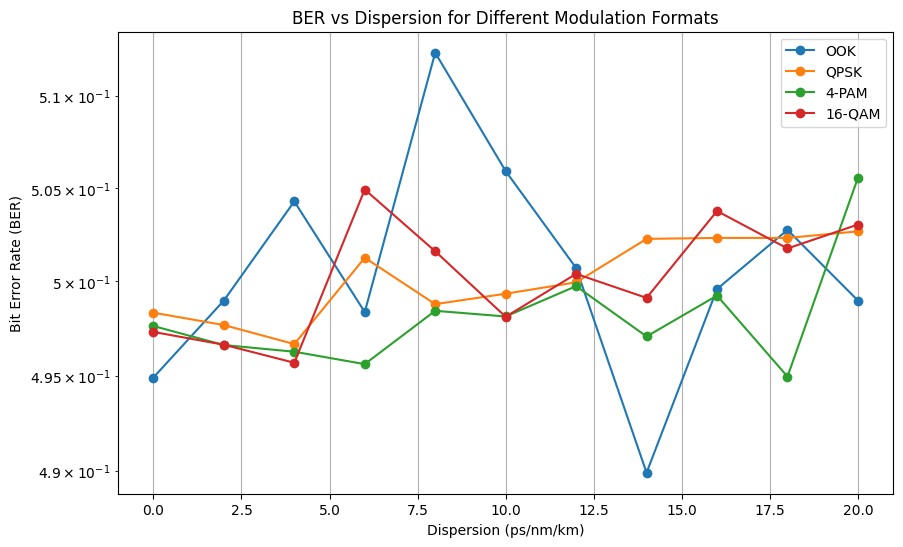


Performance Summary:
--------------------------------------------------

OOK Results:
Minimum BER: 4.90e-01
Maximum Q-factor: -5.98 dB
Optimal dispersion: 14.00 ps/nm/km

QPSK Results:
Minimum BER: 4.97e-01
Maximum Q-factor: 0.84 dB
Optimal dispersion: 4.00 ps/nm/km

4-PAM Results:
Minimum BER: 4.95e-01
Maximum Q-factor: -6.20 dB
Optimal dispersion: 18.00 ps/nm/km

16-QAM Results:
Minimum BER: 4.96e-01
Maximum Q-factor: 0.12 dB
Optimal dispersion: 4.00 ps/nm/km


In [19]:
# Simulation parameters
SpS = 16  # Samples per symbol
Rs = 40e9  # Symbol rate
Fs = SpS*Rs
modulation_formats = [
    {'name': 'OOK', 'M': 2, 'type': 'pam'},
    {'name': 'QPSK', 'M': 4, 'type': 'qam'},
    {'name': '4-PAM', 'M': 4, 'type': 'pam'},
    {'name': '16-QAM', 'M': 16, 'type': 'qam'}
]

# Test range for dispersion
dispersion_values = np.linspace(0, 20, 11)  # 0 to 20 ps/nm/km
BER_all = np.zeros((len(modulation_formats), len(dispersion_values)))
Q_factors = np.zeros((len(modulation_formats), len(dispersion_values)))

# Main simulation loop
for idx_m, mod in enumerate(tqdm(modulation_formats, desc="Testing modulation formats")):
    for idx_d, D in enumerate(tqdm(dispersion_values, desc=f"Testing {mod['name']}")):
        paramCh.D = D  # Update dispersion

        # Generate bits
        n_bits = int(np.log2(mod['M']) * 10000)
        bitsTx = np.random.randint(2, size=n_bits)

        # Modulate
        symbTx = modulateGray(bitsTx, mod['M'], mod['type'])
        symbTx = pnorm(symbTx)

        # Upsample and shape
        symbolsUp = upsample(symbTx, SpS)
        sigTx = firFilter(pulse, symbolsUp)

        # Optical modulation
        Ai = np.sqrt(Pi)
        sigTxo = mzm(Ai, sigTx.real if mod['type']=='pam' else sigTx, paramMZM)

        # Transmission
        sigCh = linearFiberChannel(sigTxo, paramCh)
        sigCh = edfa(sigCh, paramEDFA)

        # Detection
        I_Rx = photodiode(sigCh, paramPD)
        I_Rx = I_Rx/np.std(I_Rx)
        I_Rx = I_Rx[0::SpS]  # Sample at symbol centers

        # BER calculation
        if mod['type'] == 'pam':
            # PAM detection
            levels = np.linspace(-1, 1, mod['M'])
            thresholds = (levels[:-1] + levels[1:]) / 2
            symbRx = np.zeros_like(I_Rx)
            for i in range(mod['M']-1):
                symbRx[I_Rx > thresholds[i]] = i + 1
            bitsRx = np.unpackbits(symbRx.astype(np.uint8))[:bitsTx.size]
        else:
            # QAM detection
            I_Rx_complex = I_Rx + 1j * np.imag(sigCh[0::SpS])
            I_Rx_complex = I_Rx_complex / np.std(I_Rx_complex)
            sqrt_M = int(np.sqrt(mod['M']))
            constellation = np.array([complex(i, q)
                                   for i in np.linspace(-1, 1, sqrt_M)
                                   for q in np.linspace(-1, 1, sqrt_M)])
            symbRx = np.zeros_like(I_Rx_complex)
            for i, symbol in enumerate(I_Rx_complex):
                distances = np.abs(constellation - symbol)
                symbRx[i] = np.argmin(distances)
            bitsRx = np.unpackbits(symbRx.astype(np.uint8))[:bitsTx.size]

        # Calculate performance metrics
        err = np.logical_xor(bitsRx[100:-100], bitsTx[100:-100])
        BER_all[idx_m, idx_d] = np.mean(err)
        Q_factors[idx_m, idx_d] = 20*np.log10(np.abs(np.mean(I_Rx) / np.std(I_Rx)))

# Plot results
plt.figure(figsize=(10, 6))
for idx, mod in enumerate(modulation_formats):
    plt.semilogy(dispersion_values, BER_all[idx], 'o-', label=mod['name'])
plt.grid(True)
plt.xlabel('Dispersion (ps/nm/km)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs Dispersion for Different Modulation Formats')
plt.legend()
plt.show()

# Print summary
print("\nPerformance Summary:")
print("-" * 50)
for idx, mod in enumerate(modulation_formats):
    min_ber = np.min(BER_all[idx])
    max_q = np.max(Q_factors[idx])
    opt_disp = dispersion_values[np.argmin(BER_all[idx])]
    print(f"\n{mod['name']} Results:")
    print(f"Minimum BER: {min_ber:.2e}")
    print(f"Maximum Q-factor: {max_q:.2f} dB")
    print(f"Optimal dispersion: {opt_disp:.2f} ps/nm/km")